In [1]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import os
import sys
import datetime
import matplotlib.pyplot as plt
import pyfolio as pf

sys.path.insert(0, '/mnt/afml/ml_finance/mlfinlab')
from mlfinlab.data_structures import imbalance_data_structures as imbar, standard_data_structures as bar
import mlfinlab as ml

sys.path.insert(0, '/mnt/afml/ml_finance/finance_ml')
from finance_ml import sampling, features

/mnt/afml/venv/lib/python3.5/site-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


In [36]:
def evaluate(X,y,clf):
    from sklearn import metrics
    # The random forest model by itself
    y_pred_rf = clf.predict_proba(X)[:, 1]
    y_pred = clf.predict(X)
    fpr_rf, tpr_rf, _ = metrics.roc_curve(y, y_pred_rf)
    print(metrics.classification_report(y, y_pred))

    plt.figure(figsize=(9,6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf, tpr_rf, label='clf')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
    
def evaluate_multi(X_test, y_test, fit, n_classes=3):
    """
    adapted from:
        https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    """
    from sklearn import metrics
    
    print(metrics.classification_report(y_test, fit.predict(X_test)))
    
    try:
        y_score = fit.decision_function(X_test)
    except:
        y_score = fit.predict_proba(X_test)
        
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])    

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(12,8))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    lw=2
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Multiclass Bins')
    plt.legend(loc="lower right")
    plt.show()                     

In [2]:
def load_parq(fname):
    table = pq.read_table(fname)
    df = table.to_pandas()
    df = df.set_index('TIMESTAMP')
    ''' 중복된 index 제거, volume은 더해준다 '''
    df = df.sort_values(by='TIMESTAMP')  # 중복 데이터 무시
    df_v = df.groupby(df.index).sum()
    df = df.loc[~df.index.duplicated(keep='first')]
    df['V'] = df_v['V']
    df['DV'] = df_v['DV']
    return df

In [3]:
fname = 'dataset/TRADE_A233740_2018.parq'
df = load_parq(fname)

In [4]:
fname = 'dataset/TRADE_A233740_2018.csv'
bar_fname = 'dataset/DBAR_A233740_2018.csv'
if not os.path.exists(fname):
    df_csv = df.reset_index()[['TIMESTAMP', 'PRICE', 'V']]
    df_csv.columns = ['date_time', 'price', 'volume']
    df_csv['price'] = df_csv['price'].astype('float')
    df_csv.to_csv(fname, index=False)
    
if os.path.exists(bar_fname):
    dbar = pd.read_csv(bar_fname, index_col='date_time')
    dbar.index = pd.to_datetime(dbar.index)
else:
    dbar = bar.get_dollar_bars(fname, threshold=1e8)
    dbar.index = pd.to_datetime(dbar.index)
    dbar.to_csv(bar_fname)

In [5]:
# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=dbar['close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
daily_vol_mean = daily_vol.rolling(10000).mean()
cusum_events = ml.filters.cusum_filter(dbar['close'], daily_vol_mean=daily_vol_mean)

# Compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=dbar['close'], num_days=1)

Timestamp('2018-01-03 09:00:21.481000')


In [6]:
pt_sl = [1, 1]
min_ret = 0.005
triple_barrier_events = ml.labeling.get_events(close=dbar['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=3,
                                               vertical_barrier_times=vertical_barriers)

2019-06-03 18:33:21.196054 100.0% apply_pt_sl_on_t1 done after 0.1 minutes. Remaining 0.0 minutes.


In [7]:
labels_p = ml.labeling.get_bins(triple_barrier_events, dbar['close'])

In [10]:
raw_data = dbar.copy()

# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
raw_data['volatility_50'] = raw_data['log_ret'].rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=15, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

# Remove look ahead bias
raw_data = raw_data.shift(1)

In [47]:
# Get features at event dates
X = raw_data

# Drop unwanted columns
try:
    X.drop(['open', 'high', 'low', 'close', 'volume'], axis=1, inplace=True)
except Exception as e:
    print(e)

y = labels_p.loc[X.index,'bin']

"['open' 'high' 'low' 'close' 'volume'] not found in axis"


/mnt/afml/venv/lib/python3.5/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


## Ensemble Model

In [12]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from sklearn.utils import shuffle

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [38]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

from sklearn import datasets
from sklearn.metrics import roc_curve, auc
from itertools import cycle

In [48]:
y = y.dropna()
X = X.dropna()
com_idx = y.index.join(X.index).join(labels_p.index)
X = X.loc[com_idx]
y = y.loc[com_idx]
labels_p = labels_p.loc[com_idx]

In [52]:
# Split data into training, validation and test sets
y = label_binarize(y, classes=[-1,0,1])
# X_training_validation = X['2018-01-01':'2018-10-31']
# y_training_validation = y['2018-01-01':'2018-10-31']
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, shuffle=False)

In [16]:
bar_idx, t1 = sampling.get_baridx_t1(dbar, triple_barrier_events)
ind_m = sampling.get_ind_matrix(bar_idx, t1)
avgU = sampling.get_avg_uniqueness(ind_m, None)

3617it [00:00, 7011.67it/s]
/mnt/afml/venv/lib/python3.5/site-packages/scipy/sparse/base.py:597: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


In [32]:
clf0 = RandomForestClassifier(n_estimators=1000, class_weight='balanced_subsample', criterion='entropy')

clf1 = DecisionTreeClassifier(criterion='entropy', max_features='auto', class_weight='balanced')
clf1 = BaggingClassifier(base_estimator=clf1, n_estimators=1000, max_samples=avgU.mean())

clf2 = RandomForestClassifier(n_estimators=1, criterion='entropy', bootstrap=False, class_weight='balanced_subsample')
clf2 = BaggingClassifier(base_estimator=clf2, n_estimators=1000, max_samples=avgU.mean(), max_features=1.)

/mnt/afml/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/mnt/afml/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.49      0.48      0.48       248
           1       0.00      0.00      0.00        26
           2       0.47      0.31      0.38       253

   micro avg       0.48      0.38      0.42       527
   macro avg       0.32      0.26      0.29       527
weighted avg       0.45      0.38      0.41       527
 samples avg       0.37      0.38      0.37       527



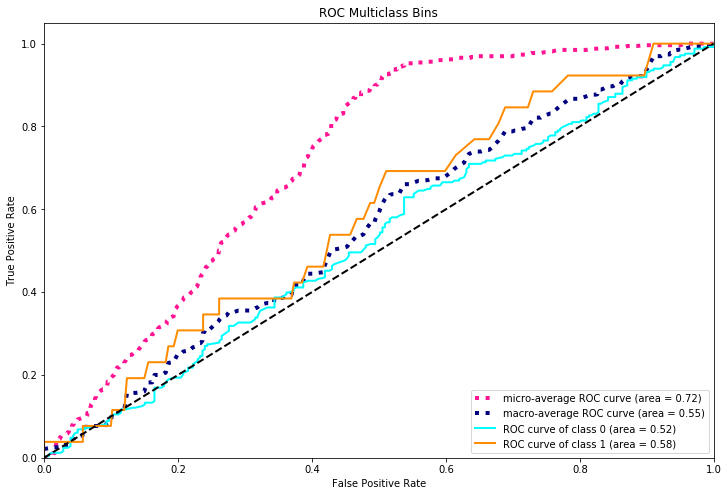

In [53]:
clf = OneVsRestClassifier(clf0)
fit = clf.fit(X_train,y_train)
evaluate_multi(X_validate, y_validate, fit, n_classes=len(np.unique(y)))

/mnt/afml/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/mnt/afml/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.47      0.42      0.44       248
           1       0.00      0.00      0.00        26
           2       0.47      0.29      0.36       253

   micro avg       0.47      0.34      0.39       527
   macro avg       0.31      0.24      0.27       527
weighted avg       0.45      0.34      0.38       527
 samples avg       0.33      0.34      0.33       527



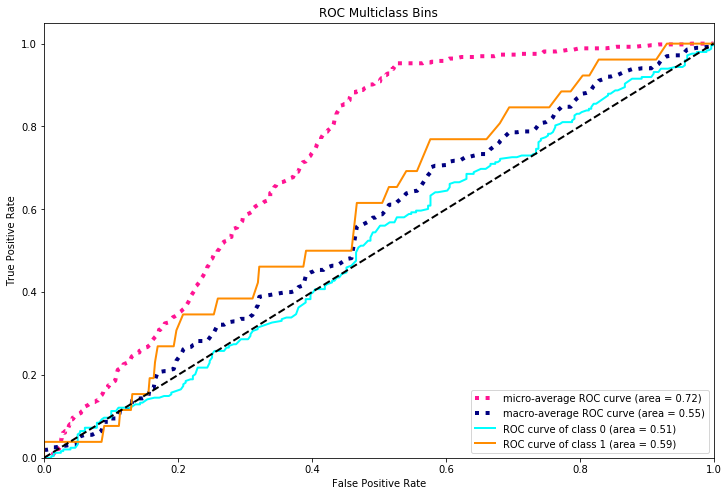

In [54]:
clf = OneVsRestClassifier(clf1)
fit = clf.fit(X_train,y_train)
evaluate_multi(X_validate, y_validate, fit, n_classes=len(np.unique(y)))

/mnt/afml/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/mnt/afml/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.49      0.45      0.47       248
           1       0.00      0.00      0.00        26
           2       0.46      0.30      0.36       253

   micro avg       0.47      0.35      0.41       527
   macro avg       0.31      0.25      0.28       527
weighted avg       0.45      0.35      0.39       527
 samples avg       0.35      0.35      0.35       527



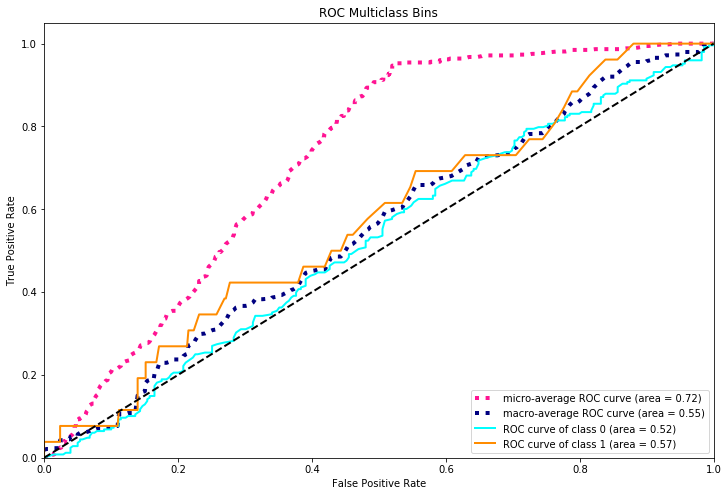

In [55]:
clf = OneVsRestClassifier(clf2)
fit = clf.fit(X_train,y_train)
evaluate_multi(X_validate, y_validate, fit, n_classes=len(np.unique(y)))